# Notebook 3: Batched IoT Rolling Analytics

## Introduction

This notebook demonstrates how to efficiently process **multiple time-series simultaneously** using HPCSeries.

**Key question**: When you have data from many sensors (IoT devices, stock tickers, climate stations), how do you efficiently compute rolling statistics and aggregate across all sensors?

We'll use temperature data from 10 IoT sensors in a smart building, with 100 time steps per sensor.

---

## Use Case: Smart Building Climate Control

Imagine a smart building with temperature sensors in different rooms:
- **10 sensors** (different rooms/zones)
- **100 minutes** of data (1-minute sampling)
- Need to:
  1. Smooth each sensor's readings (rolling mean)
  2. Compute building-wide statistics (mean across sensors)
  3. Detect any sensors reporting anomalies

---

## Setup

Import HPCSeries and load the multi-sensor IoT data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hpcs
import time

# Display library info
print(f"HPCSeries version: {hpcs.__version__}")
print(f"SIMD ISA: {hpcs.simd_info()['isa']}")
print()

HPCSeries version: 0.7.0
=== HPCS CPU Detection v0.5 ===
Logical cores:   8
Physical cores:  4
Optimal threads: 4

L1 cache (KB):   32
L2 cache (KB):   512
L3 cache (KB):   4096

NUMA nodes:      1
Cores per node:  4

CPU vendor:      AuthenticAMD
SIMD width:      256 bits
Has SSE2:        T
Has AVX:         T
Has AVX2:        T
Has AVX-512:     F
Has NEON:        F
Has FMA3:        T
SIMD ISA: AVX2



[SIMD] Registered OpenMP SIMD reduction kernels
[SIMD] Registered OpenMP SIMD rolling operations
[SIMD] Z-score kernels initialized
[SIMD Debug] AVX-512=0, AVX2=1, AVX=1, SSE2=1
[SIMD] Detected ISA: AVX2 (256-bit)


## Load Data

Load the multi-sensor dataset with 10 temperature sensors over 100 minutes.

In [2]:
# Load IoT sensor data
df = pd.read_csv('data/iot_sensors_multiseries.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract sensor columns as 2D NumPy array (time x sensors)
sensor_cols = [col for col in df.columns if col.startswith('sensor_')]
sensor_data = df[sensor_cols].values

n_timesteps, n_sensors = sensor_data.shape

print(f"Dataset: {n_sensors} sensors, {n_timesteps} time steps")
print(f"Shape: {sensor_data.shape} (time x sensors)")
print(f"Temperature range: {sensor_data.min():.1f}°C - {sensor_data.max():.1f}°C")
print()

# Show first few rows
df.head()

Dataset: 10 sensors, 100 time steps
Shape: (100, 10) (time x sensors)
Temperature range: 20.7°C - 27.7°C



,timestamp,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10
0,2024-01-01 00:00:00,21.3,22.1,20.8,21.7,22.3,21.9,22.5,21.2,22.8,21.5
1,2024-01-01 00:01:00,21.4,22.0,20.9,21.8,22.2,22.0,22.4,21.3,22.7,21.6
2,2024-01-01 00:02:00,21.2,22.2,20.7,21.6,22.4,21.8,22.6,21.1,22.9,21.4
3,2024-01-01 00:03:00,21.5,22.1,21.0,21.9,22.3,22.1,22.5,21.4,22.8,21.7
4,2024-01-01 00:04:00,21.3,22.3,20.8,21.7,22.5,21.9,22.7,21.2,23.0,21.5


## Visualize Raw Sensor Data

Plot all 10 sensor time-series together.

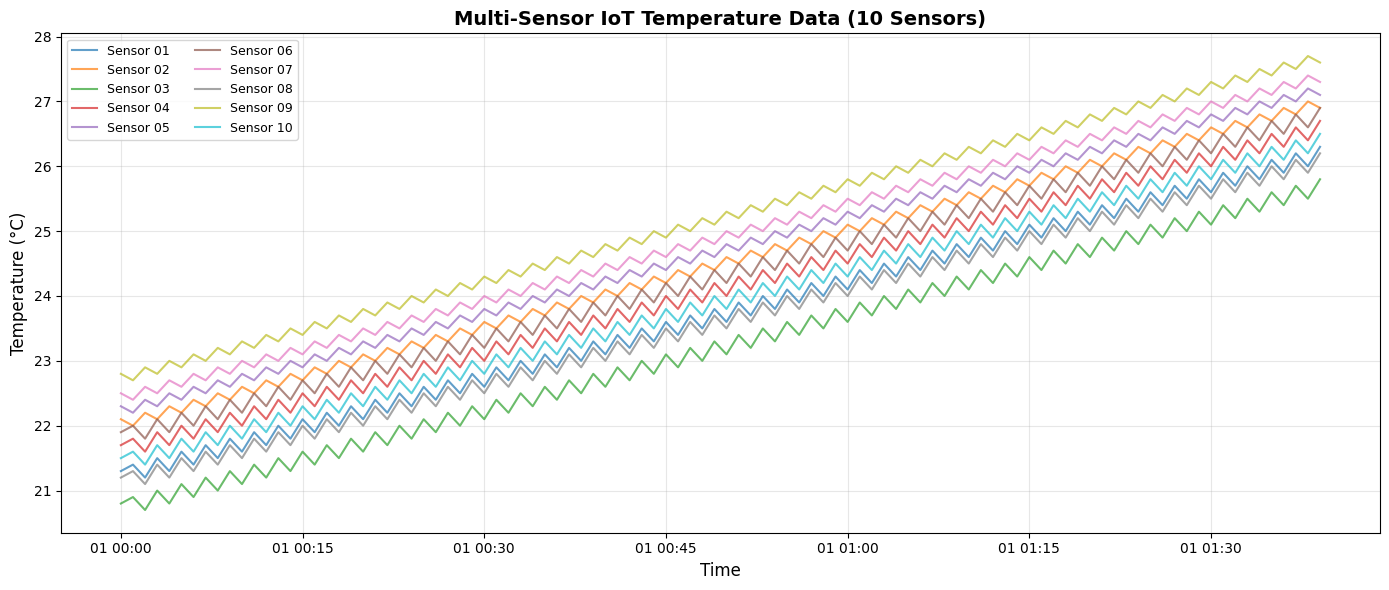

In [3]:
plt.figure(figsize=(14, 6))

for i, col in enumerate(sensor_cols):
    plt.plot(df['timestamp'], df[col], alpha=0.7, linewidth=1.5, label=f'Sensor {i+1:02d}')

plt.xlabel('Time', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.title('Multi-Sensor IoT Temperature Data (10 Sensors)', fontsize=14, fontweight='bold')
plt.legend(loc='upper left', ncol=2, fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Method 1: Process Each Sensor Separately

Compute a **5-minute rolling mean** for each sensor using a Python loop with HPCSeries operations.

In [4]:
window = 5

# Apply rolling mean to each sensor column
smoothed_data = np.zeros_like(sensor_data)

start = time.perf_counter()
for i in range(n_sensors):
    smoothed_data[:, i] = hpcs.rolling_mean(sensor_data[:, i], window)
elapsed = time.perf_counter() - start

print(f"Processed {n_sensors} sensors with {window}-minute rolling mean")
print(f"Total time: {elapsed*1000:.2f} ms")
print(f"Per-sensor: {elapsed*1000/n_sensors:.2f} ms")
print()

Processed 10 sensors with 5-minute rolling mean
Total time: 0.71 ms
Per-sensor: 0.07 ms



## Visualize Smoothed Data

Compare raw vs smoothed sensor readings.

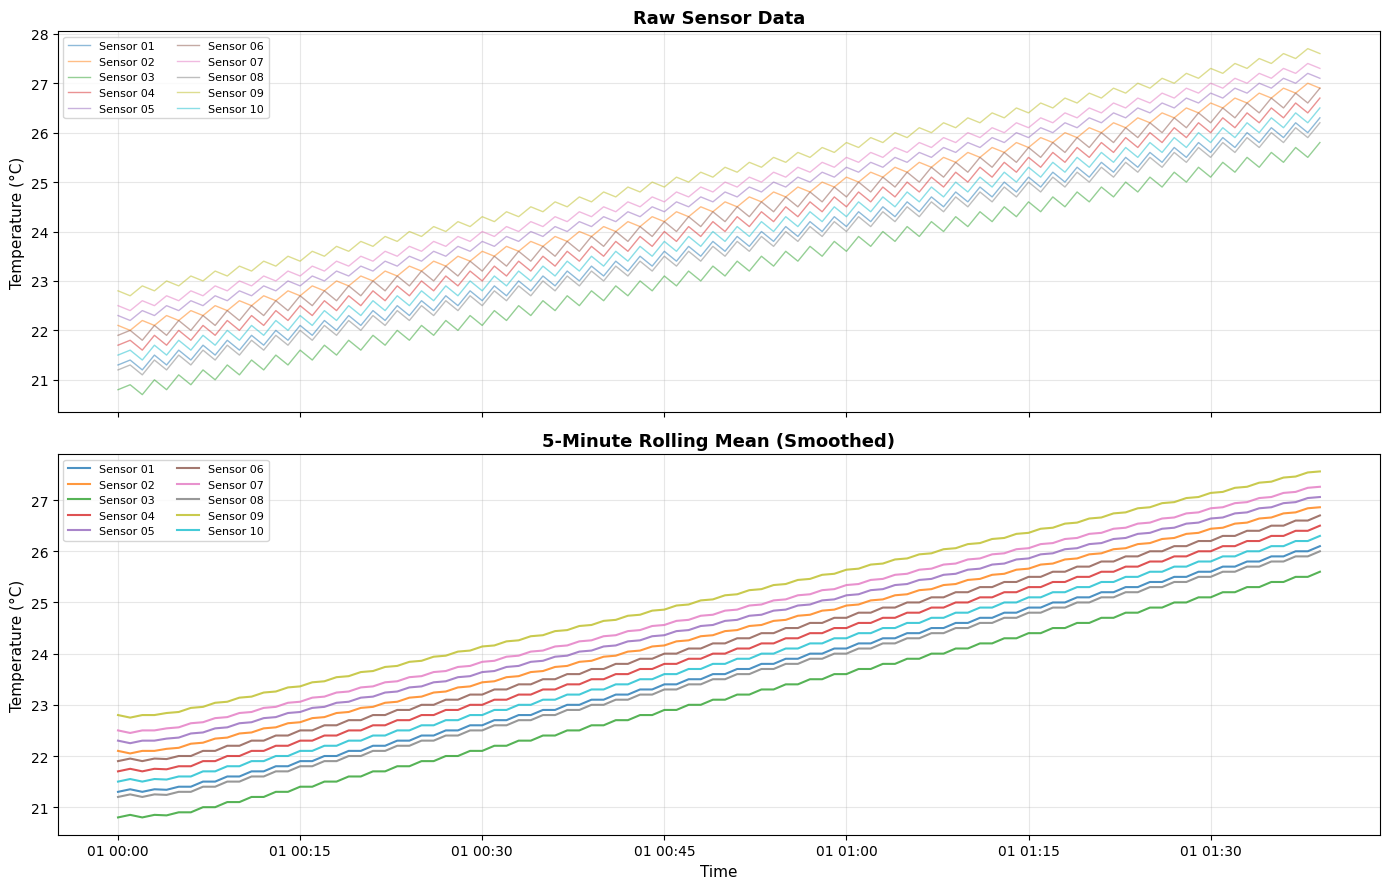

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(14, 9), sharex=True)

# Plot 1: Raw data
for i, col in enumerate(sensor_cols):
    axes[0].plot(df['timestamp'], sensor_data[:, i], alpha=0.5, linewidth=1.0, label=f'Sensor {i+1:02d}')

axes[0].set_ylabel('Temperature (°C)', fontsize=11)
axes[0].set_title('Raw Sensor Data', fontsize=13, fontweight='bold')
axes[0].legend(loc='upper left', ncol=2, fontsize=8)
axes[0].grid(True, alpha=0.3)

# Plot 2: Smoothed data
for i, col in enumerate(sensor_cols):
    axes[1].plot(df['timestamp'], smoothed_data[:, i], alpha=0.8, linewidth=1.5, label=f'Sensor {i+1:02d}')

axes[1].set_xlabel('Time', fontsize=11)
axes[1].set_ylabel('Temperature (°C)', fontsize=11)
axes[1].set_title(f'{window}-Minute Rolling Mean (Smoothed)', fontsize=13, fontweight='bold')
axes[1].legend(loc='upper left', ncol=2, fontsize=8)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Method 2: Aggregate Across Sensors

Compute **building-wide statistics** by aggregating across all sensors at each time step.

HPCSeries provides `axis_mean()` for efficient column-wise operations on 2D arrays.

In [6]:
# Convert to Fortran-order (column-major) for efficient axis operations
sensor_data_f = np.asfortranarray(sensor_data)

# Compute mean across sensors (axis=1 means reduce across columns, giving per-row means)
building_mean = hpcs.axis_mean(sensor_data_f, axis=1)

print(f"Building-wide mean temperature computed using axis_mean()")
print(f"Result shape: {building_mean.shape}")
print(f"Mean of means: {hpcs.mean(building_mean):.2f}°C")
print()

Building-wide mean temperature computed using axis_mean()
Result shape: (100,)
Mean of means: 24.21°C

=== HPCS CPU Detection v0.5 ===
Logical cores:   8
Physical cores:  4
Optimal threads: 4

L1 cache (KB):   32
L2 cache (KB):   512
L3 cache (KB):   4096

NUMA nodes:      1
Cores per node:  4

CPU vendor:      AuthenticAMD
SIMD width:      256 bits
Has SSE2:        T
Has AVX:         T
Has AVX2:        T
Has AVX-512:     F
Has NEON:        F
Has FMA3:        T


[SIMD Debug] AVX-512=0, AVX2=1, AVX=1, SSE2=1
[SIMD] Detected ISA: AVX2 (256-bit)


## Visualize Building-Wide Statistics

Show individual sensors vs the building-wide average.

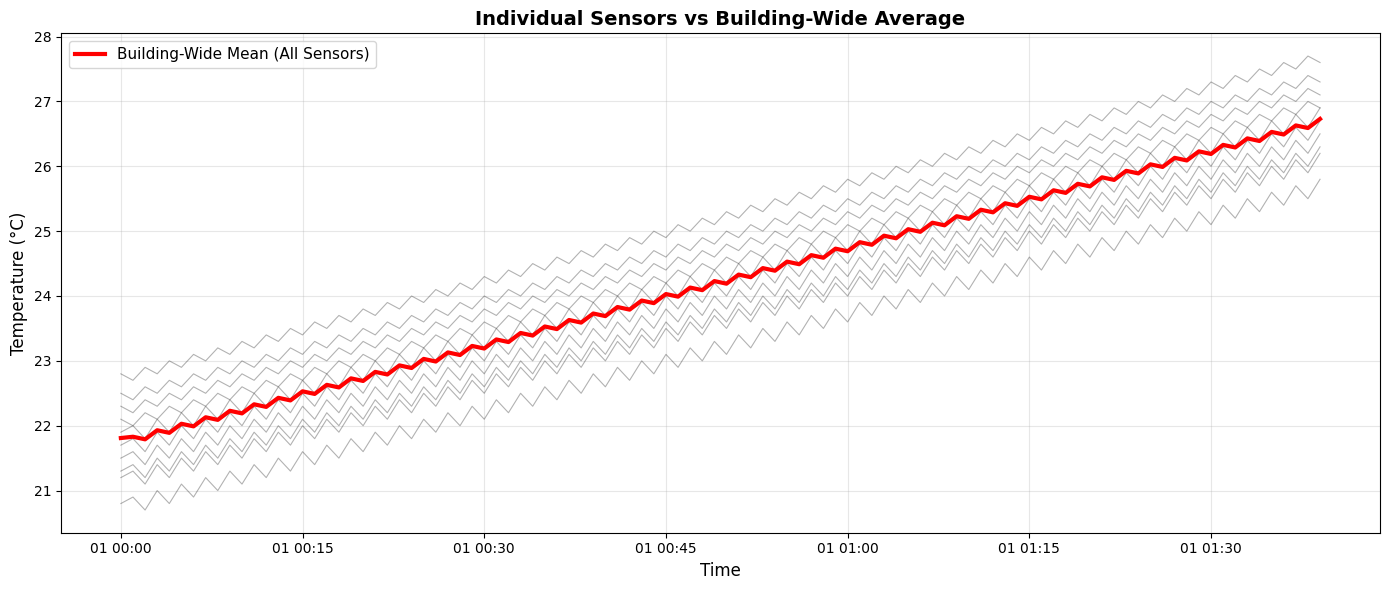

In [8]:
plt.figure(figsize=(14, 6))

# Plot all sensors (faint)
for i in range(n_sensors):
    plt.plot(df['timestamp'], sensor_data[:, i], alpha=0.3, linewidth=0.8, color='black')

# Plot building-wide mean (bold)
plt.plot(df['timestamp'], building_mean, linewidth=3, color='red', label='Building-Wide Mean (All Sensors)')

plt.xlabel('Time', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.title('Individual Sensors vs Building-Wide Average', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Method 3: Per-Sensor Summary Statistics

Compute statistics for each sensor (e.g., mean, median, std) to identify outlier sensors.

In [9]:
# Compute per-sensor statistics
sensor_stats = pd.DataFrame({
    'sensor': sensor_cols,
    'mean': [hpcs.mean(sensor_data[:, i]) for i in range(n_sensors)],
    'median': [hpcs.median(sensor_data[:, i]) for i in range(n_sensors)],
    'std': [hpcs.std(sensor_data[:, i]) for i in range(n_sensors)],
    'min': [hpcs.min(sensor_data[:, i]) for i in range(n_sensors)],
    'max': [hpcs.max(sensor_data[:, i]) for i in range(n_sensors)],
})

print("Per-Sensor Summary Statistics:")
print("=" * 70)
print(sensor_stats.to_string(index=False))
print()

# Identify coldest and warmest sensors
coldest_idx = sensor_stats['mean'].idxmin()
warmest_idx = sensor_stats['mean'].idxmax()

print(f"Coldest sensor: {sensor_stats.loc[coldest_idx, 'sensor']} (mean = {sensor_stats.loc[coldest_idx, 'mean']:.2f}°C)")
print(f"Warmest sensor: {sensor_stats.loc[warmest_idx, 'sensor']} (mean = {sensor_stats.loc[warmest_idx, 'mean']:.2f}°C)")

Per-Sensor Summary Statistics:
   sensor   mean  median      std  min  max
sensor_01 23.702    23.7 1.454702 21.2 26.3
sensor_02 24.500    24.5 1.451227 22.0 27.0
sensor_03 23.202    23.2 1.454702 20.7 25.8
sensor_04 24.102    24.1 1.454702 21.6 26.7
sensor_05 24.700    24.7 1.451227 22.2 27.2
sensor_06 24.302    24.3 1.454702 21.8 26.9
sensor_07 24.900    24.9 1.451227 22.4 27.4
sensor_08 23.602    23.6 1.454702 21.1 26.2
sensor_09 25.200    25.2 1.451227 22.7 27.7
sensor_10 23.902    23.9 1.454702 21.4 26.5

Coldest sensor: sensor_03 (mean = 23.20°C)
Warmest sensor: sensor_09 (mean = 25.20°C)


## Anomaly Detection: Identify Deviant Sensors

Detect which sensors are consistently deviating from the building-wide average.

In [10]:
# Compute deviation of each sensor from building mean
deviations = np.zeros(n_sensors)
for i in range(n_sensors):
    # Compute mean absolute deviation from building average
    deviations[i] = hpcs.mean(np.abs(sensor_data[:, i] - building_mean))

# Create deviation report
deviation_report = pd.DataFrame({
    'sensor': sensor_cols,
    'mean_abs_deviation': deviations
}).sort_values('mean_abs_deviation', ascending=False)

print("Sensor Deviation from Building Average:")
print("=" * 50)
print(deviation_report.to_string(index=False))
print()

# Flag sensors with high deviation (> 1.5°C average deviation)
threshold = 1.5
outlier_sensors = deviation_report[deviation_report['mean_abs_deviation'] > threshold]

if len(outlier_sensors) > 0:
    print(f"⚠️  Sensors with high deviation (> {threshold}°C):")
    for _, row in outlier_sensors.iterrows():
        print(f"  - {row['sensor']}: {row['mean_abs_deviation']:.2f}°C")
else:
    print(f"✓ All sensors within {threshold}°C of building average.")

Sensor Deviation from Building Average:
   sensor  mean_abs_deviation
sensor_03              1.0092
sensor_09              0.9888
sensor_07              0.6888
sensor_08              0.6092
sensor_01              0.5092
sensor_05              0.4888
sensor_10              0.3092
sensor_02              0.2888
sensor_04              0.1092
sensor_06              0.0908

✓ All sensors within 1.5°C of building average.


## Performance Benchmark: Scaling to Many Sensors

Test how HPCSeries performs when processing a **large number of sensors**.

In [11]:
# Simulate large-scale IoT deployment
n_sensors_large = 1000
n_timesteps_large = 10_000

print(f"Benchmark: {n_sensors_large} sensors, {n_timesteps_large} time steps")
print(f"Total data points: {n_sensors_large * n_timesteps_large:,}")
print()

# Generate synthetic sensor data
large_sensor_data = np.random.randn(n_timesteps_large, n_sensors_large) * 2 + 22

# Benchmark: Rolling mean for all sensors
print("Task 1: Compute 5-minute rolling mean for all sensors")
start = time.perf_counter()
for i in range(n_sensors_large):
    _ = hpcs.rolling_mean(large_sensor_data[:, i], 5)
elapsed = time.perf_counter() - start
print(f"  Time: {elapsed:.3f} sec")
print(f"  Throughput: {n_sensors_large * n_timesteps_large / elapsed / 1e6:.1f} M values/sec")
print()

# Benchmark: Axis mean (building-wide average)
print("Task 2: Compute building-wide mean (axis operation)")
large_sensor_data_f = np.asfortranarray(large_sensor_data)
start = time.perf_counter()
_ = hpcs.axis_mean(large_sensor_data_f, axis=1)
elapsed = time.perf_counter() - start
print(f"  Time: {elapsed*1000:.2f} ms")
print(f"  Throughput: {n_sensors_large * n_timesteps_large / elapsed / 1e6:.1f} M values/sec")
print()

print(f"✓ HPCSeries efficiently handles {n_sensors_large} sensors with {n_timesteps_large:,} time steps!")

Benchmark: 1000 sensors, 10000 time steps
Total data points: 10,000,000

Task 1: Compute 5-minute rolling mean for all sensors
  Time: 0.312 sec
  Throughput: 32.1 M values/sec

Task 2: Compute building-wide mean (axis operation)
  Time: 43.81 ms
  Throughput: 228.3 M values/sec

✓ HPCSeries efficiently handles 1000 sensors with 10,000 time steps!


## What We Learned

### Key Takeaways:

1. **Multi-sensor processing** is common in IoT, finance, and climate monitoring.
   - HPCSeries makes it easy to process many time-series efficiently.

2. **Rolling operations** can be applied to each sensor using a simple loop.
   - `hpcs.rolling_mean()` is fast enough that looping over sensors is practical.

3. **Axis operations** efficiently aggregate across sensors.
   - `hpcs.axis_mean()` computes building-wide or fleet-wide statistics.
   - Use Fortran-order arrays for optimal performance.

4. **HPCSeries scales** to thousands of sensors with millions of data points.
   - SIMD acceleration and OpenMP parallelization handle large-scale deployments.

### HPCSeries Functions Used:

- `hpcs.rolling_mean()` — Smooth each sensor's time-series
- `hpcs.axis_mean()` — Aggregate across sensors
- `hpcs.mean()`, `hpcs.median()`, `hpcs.std()` — Per-sensor statistics
- `hpcs.min()`, `hpcs.max()` — Range detection

### Common Use Cases:

| Domain | Use Case | HPCSeries Approach |
|--------|----------|--------------------|
| **IoT** | Smart buildings, industrial sensors | Rolling mean per sensor + axis aggregation |
| **Finance** | Portfolio of stocks | Rolling stats per ticker + axis reductions |
| **Climate** | Weather station networks | Smooth per station + spatial averaging |
| **Manufacturing** | Quality control sensors | Detect deviant sensors via deviations |
| **Energy** | Smart grid monitoring | Rolling analytics per meter + grid-wide stats |

---

## Next Steps

See the next notebook:
- **Notebook 4**: Axis reductions for column-wise statistics on financial/market data
